# Decision tree example with toy data
To illustrate the concept of risk and safe wrappers, this example uses:
- a simplified dataset
- a decision tree classifier

### Please note this is only so we can fit the illustrations nicely on a screen!

We'll start by importing some standard libraries, making our 'toy data, and showing what the first five rows look like

In [1]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from generate_data import make_toy_data

In [16]:
toy_df = make_toy_data([5, 50, 1],seed = 4009)
toy_df.head()
feature_names = ('age','smoker','resting_hr','weight','employed','label')
labels_present = toy_df['label'].unique()
print(f'The different labels present are {labels_present}')

The different labels present are [0 1 2]


## Now imagine our researcher decides to investigate what factors lead to disease risk,
>- And they are not a ML expert 
>- so they split their data into features (X) and labels (y) to be predicted
>- and use the default algorithm settings to learn a decision tree

In [17]:
train_y = toy_df['label']
train_X = toy_df.drop('label', axis=1)
tree = DecisionTreeClassifier()
tree.fit(train_X, train_y)

print( f'Training set accuracy = {100*tree.score(train_X,train_y)}%')


Training set accuracy = 100.0%


## Great so far, ...  but what does this tree look like?

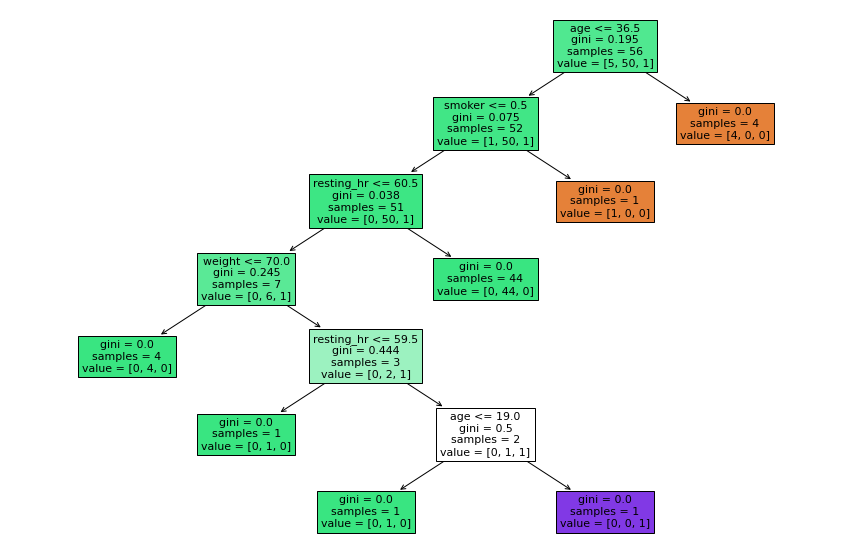

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
output = plot_tree(tree, filled=True, ax=ax, fontsize=11,feature_names = feature_names)

## What's the problem here?
There's exactly one person with 
<div class="float-container">

  <div style="float:left">
      <h3>Label 2 (purple box)</h3>
      <ul>
          <li>19 &lt; age &lt; 36.5 </li>
          <li> smoker = 0 </li>
          <li>  59.5 &lt; resting heart rate &lt; 60.5</li>
          <li>70 &lt; weight </li>
      </ul>
  </div>
  
  <div style="float:right">
          <h3> Label 1 (green box)</h3>
      <ul>
          <li> age &lt; 19 </li>
          <li> smoker = 0 </li>
          <li>  59.5 &lt; resting heart rate &lt; 60.5</li>
          <li>70 &lt; weight </li>
      </ul>
  </div>
  
</div>

 


and even if that is not enough to identify someone uniquely, its not hard to imagine how this could be even more disclosive if we didn't restrict the tree to fit on one slide ...  

### Diligent user realises problem, and changes their code to enforce at least *k* samples in each leaf
let's say they assume this is equivalent to enforcing *k*-anonymity

Training set accuracy with threshold rule enforced is 0.9464285714285714


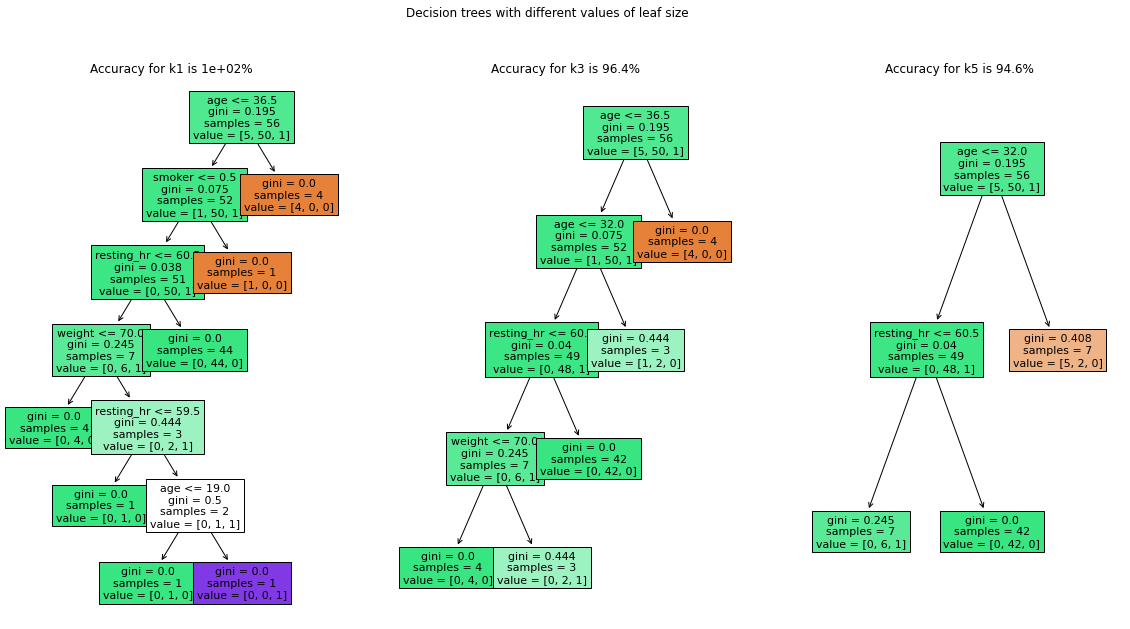

In [34]:
manualDT = DecisionTreeClassifier(min_samples_leaf=5, random_state=1)
manualDT.fit(train_X, train_y)

print(f"Training set accuracy with threshold rule enforced is {manualDT.score(train_X,train_y)}")

fig2, ax2 = plt.subplots(1, 3, figsize=(20, 10))
fig2.suptitle('Decision trees with different values of leaf size')
for k in (1,3,5):
    column=int((k-1)/2)
    manualDT = DecisionTreeClassifier(min_samples_leaf=k, random_state=1)
    manualDT.fit(train_X, train_y)
    output = plot_tree(manualDT, filled=True, ax=ax2[column], fontsize=11,feature_names = feature_names)
    ax2[column].set_title(f'Accuracy for k{k} is {100*manualDT.score(train_X,train_y):.3}%')

Not for presentation - this is how i found that seed to use

new best with complexity 5 for seed 0
new best with complexity 6 for seed 1


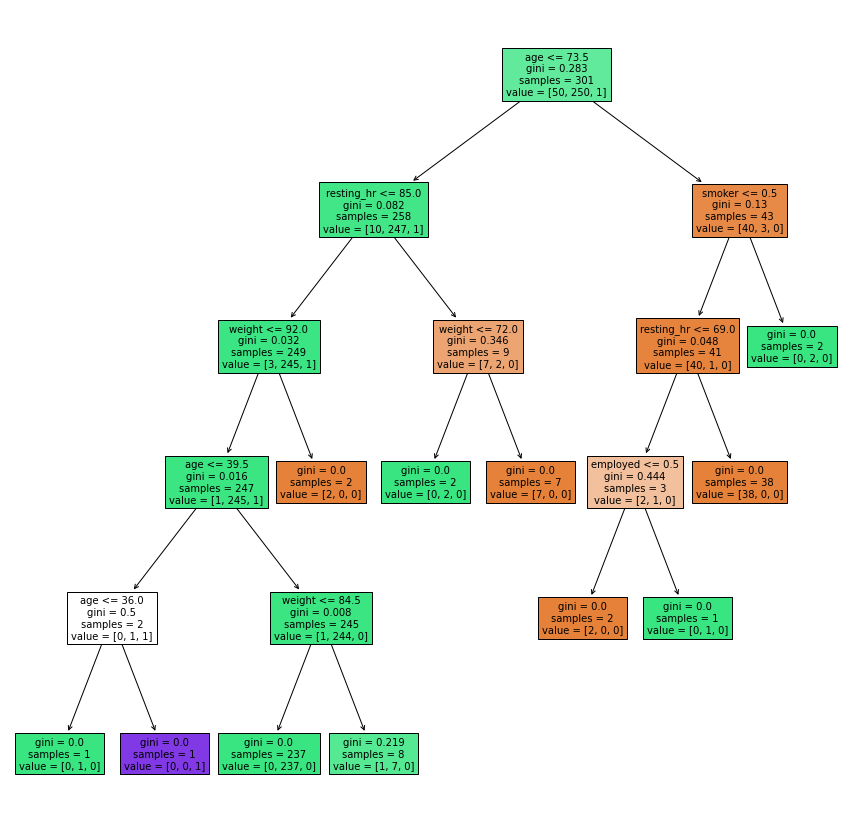

In [15]:
pathlength = 0
bestsofar=0
for attempts in range (20000):
    seed=attempts*10
    toy_df = make_toy_data([50, 250, 1],seed)
    train_y = toy_df['label']
    train_X = toy_df.drop('label', axis=1)
    tree = DecisionTreeClassifier(max_depth= 5)
    tree.fit(train_X, train_y)
    paths = tree.decision_path(train_X)
    complexity =  paths[-1].sum()
    if(complexity>bestsofar):
        bestsofar = complexity
        print(f'new best with complexity {complexity} for seed {attempts}')
        plot_tree(tree, filled=True,  fontsize=10,feature_names = feature_names)
        fig = plt.gcf()
        fig.set_size_inches(15,15)
    if(complexity>=9):
        break

 19 < age < 36.5
 smoker = 0
 59.5 < resting heart rate <= 60.5
 70 < weight